In [95]:
from vqf.preprocessing import create_clauses
from IPython.display import display
import sys
from cython import cdivision

import warnings
warnings.filterwarnings('ignore')

sys.path.append(f"./../")
from src.clause_utils import table_form
from src import Clause, SetsGraph

In [96]:
# p = 5
# q = 3

p = 31
q = 23

# p = 11
# q = 7

# p = 241
# q = 233

# p = 13
# q = 11

# p = 557
# q = 523

m = p * q

p_bits, q_bits, z_bits, clauses = create_clauses(
    m, apply_preprocessing=False, verbose=False
)

for c in clauses:
    display(c)

p_0*q_0 - 1

p_0*q_1 + p_1*q_0 - 2*z_1_2 - 4*z_1_3 - 8*z_1_4 - 16*z_1_5 - 32*z_1_6 - 64*z_1_7 - 128*z_1_8 - 256*z_1_9

p_0*q_2 + p_1*q_1 + p_2*q_0 + z_1_2 - 2*z_2_3 - 4*z_2_4 - 8*z_2_5 - 16*z_2_6 - 32*z_2_7 - 64*z_2_8 - 128*z_2_9

p_0*q_3 + p_1*q_2 + p_2*q_1 + p_3*q_0 + z_1_3 + z_2_3 - 2*z_3_4 - 4*z_3_5 - 8*z_3_6 - 16*z_3_7 - 32*z_3_8 - 64*z_3_9 - 1

p_0*q_4 + p_1*q_3 + p_2*q_2 + p_3*q_1 + p_4*q_0 + z_1_4 + z_2_4 + z_3_4 - 2*z_4_5 - 4*z_4_6 - 8*z_4_7 - 16*z_4_8 - 32*z_4_9

p_1*q_4 + p_2*q_3 + p_3*q_2 + p_4*q_1 + p_5*q_0 + z_1_5 + z_2_5 + z_3_5 + z_4_5 - 2*z_5_6 - 4*z_5_7 - 8*z_5_8 - 16*z_5_9

p_2*q_4 + p_3*q_3 + p_4*q_2 + p_5*q_1 + p_6*q_0 + z_1_6 + z_2_6 + z_3_6 + z_4_6 + z_5_6 - 2*z_6_7 - 4*z_6_8 - 8*z_6_9 - 1

p_3*q_4 + p_4*q_3 + p_5*q_2 + p_6*q_1 + p_7*q_0 + z_1_7 + z_2_7 + z_3_7 + z_4_7 + z_5_7 + z_6_7 - 2*z_7_8 - 4*z_7_9 - 1

p_4*q_4 + p_5*q_3 + p_6*q_2 + p_7*q_1 + p_8*q_0 + z_1_8 + z_2_8 + z_3_8 + z_4_8 + z_5_8 + z_6_8 + z_7_8 - 2*z_8_9

p_5*q_4 + p_6*q_3 + p_7*q_2 + p_8*q_1 + p_9*q_0 + z_1_9 + z_2_9 + z_3_9 + z_4_9 + z_5_9 + z_6_9 + z_7_9 + z_8_9 - 1

p_6*q_4 + p_7*q_3 + p_8*q_2 + p_9*q_1

p_7*q_4 + p_8*q_3 + p_9*q_2

p_8*q_4 + p_9*q_3

p_9*q_4

In [97]:
p_bits_simple, q_bits_simple, z_bits_simple, simplified_clauses = create_clauses(
    m, apply_preprocessing=True, verbose=False
)

for c in simplified_clauses:
    display(c)

0

0

q_1 + q_2 - z_2_3 - 2*z_2_4

p_3 + 2*q_1*q_2 + q_3 + z_2_3 - 2*z_3_4 - 4*z_3_5 - 1

p_3*q_1 + p_4 + q_1*q_3 + q_2 + q_4 + z_2_4 + z_3_4 - 2*z_4_5 - 4*z_4_6

p_3*q_2 + p_4*q_1 + p_5 + q_1*q_4 + q_2*q_3 + z_3_5 + z_4_5 - 2*z_5_6 - 4*z_5_7

p_3*q_3 + p_4*q_2 + p_5*q_1 + p_6 + q_2*q_4 + z_4_6 + z_5_6 - 2*z_6_7 - 4*z_6_8 - 1

p_3*q_4 + p_4*q_3 + p_5*q_2 + p_6*q_1 + p_7 + z_5_7 + z_6_7 - 2*z_7_8 - 4*z_7_9 - 1

p_4*q_4 + p_5*q_3 + p_6*q_2 + p_7*q_1 + p_8 + z_6_8 + z_7_8 - 2*z_8_9

p_5*q_4 + p_6*q_3 + p_7*q_2 + p_8*q_1 + p_9 + z_7_9 + z_8_9 - 1

p_6*q_4 + p_7*q_3 + p_8*q_2 + p_9*q_1

p_7*q_4 + p_8*q_3 + p_9*q_2

p_8*q_4 + p_9*q_3

p_9*q_4

In [99]:
@cdivision(True)
def get_space_eff_clauses(simplified_clauses):
    eff_clauses = {}
    for c in simplified_clauses:
        if c != 0:
            c = Clause(c)
            table = c.reduce_space().remove_carry_bits()
            bits = table.bits
            eff_clauses[table] = bits
    return eff_clauses

    
eff_clauses = get_space_eff_clauses(simplified_clauses)

for bits in eff_clauses.values():
    print(bits)

{q_2, q_1}
{p_3, q_3, q_2, q_1}
{q_4, q_2, p_4, p_3, q_3, q_1}
{q_4, q_2, p_4, p_3, p_5, q_3, q_1}
{p_6, q_4, p_4, p_3, q_3, p_5, q_2, q_1}
{q_4, p_6, p_4, p_3, q_3, p_5, p_7, q_2, q_1}
{q_4, p_6, p_4, p_8, q_3, p_5, p_7, q_2, q_1}
{q_4, p_6, p_9, p_8, q_3, p_5, p_7, q_2, q_1}
{p_6, q_4, p_9, p_8, q_3, p_7, q_2, q_1}
{q_4, p_9, p_8, q_3, p_7, q_2}
{p_8, q_3, p_9, q_4}
{q_4, p_9}


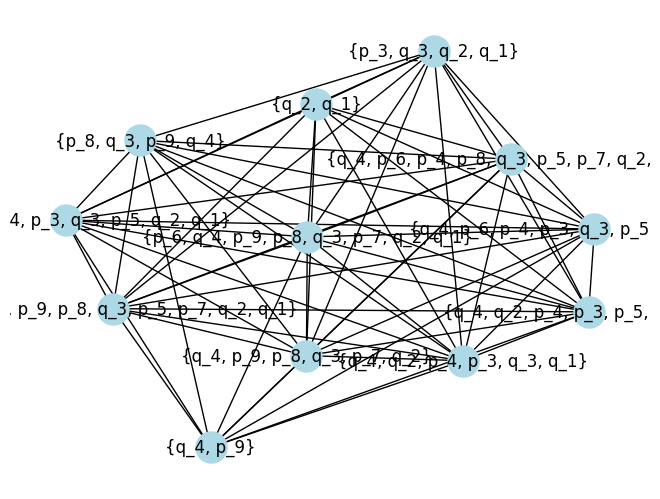

In [ ]:
pq_bits = list(eff_clauses.values())
graph = SetsGraph(pq_bits)
disjoint_sets = graph.disjoint_sets
graph.draw()

In [ ]:
def get_best_bits_table(eff_clauses):
    min_r = float("inf")  # Initialize min_r to infinity
    best_table = None  # Initialize best_table to None
    tables = eff_clauses.keys()

    for t in tables:
        r = t.calc_r()
        if r < min_r:
            min_r = r
            best_table = t.table

    return best_table


# Usage
best_clause = get_best_bits_table(eff_clauses)
display(best_clause)

,p_6,q_4,p_8,q_2,p_7,q_3,p_9,q_1
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
76,1,0,1,0,0,1,0,1
77,1,0,1,0,0,1,1,0
78,1,0,1,0,1,0,0,0
79,1,0,1,0,1,0,0,1


In [ ]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # Value not found

In [ ]:
disjoint_sets

[{q_1, q_2}, {p_8, p_9, q_3, q_4}]

In [ ]:
def get_superposition_tables(eff_clauses, disjoint_sets):
    superposition_tables = []
    if len(disjoint_sets) == 0:
        best_clause = get_best_bits_table(eff_clauses)
        superposition_tables.append(best_clause)

    else:
        for s in disjoint_sets:
            table = get_key_by_value(eff_clauses, s).table
            superposition_tables.append(table)

    return superposition_tables


superposition_tables = get_superposition_tables(eff_clauses, disjoint_sets)

for table in superposition_tables:
    display(table)

,q_2,q_1
0,0,0
1,0,1
2,1,0
3,1,1


,p_8,q_3,p_9,q_4
0,0,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,1
4,0,1,0,0
5,0,1,0,1
6,1,0,0,0
7,1,0,1,0
8,1,1,0,0
